In [1]:
# Referenced from https://github.com/DL4mHealth/COMET/blob/main/data_preprocessing/PTB/PTB_preprocessing.ipynb
import os
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datautils import normalize, resample, R_Peaks, trial2sample, sample2trial

In [2]:
# specify the unziped data path and diagnostics file path
data_path = "../Training_WFDB"
label_path = "../Training_WFDB/REFERENCE.csv"

In [3]:
labels = pd.read_csv(label_path)

In [4]:
labels = labels.iloc[:, :2]

In [5]:
labels

Recording  First_label
0        A0001            5
1        A0002            1
2        A0003            2
3        A0004            2
4        A0005            7
...        ...          ...
6872     A6873            3
6873     A6874            8
6874     A6875            4
6875     A6876            2
6876     A6877            7

[6877 rows x 2 columns]

In [6]:
records_name = labels["Recording"].values
len(records_name)

6877

In [7]:
# get median R-Peak intervals for all trials, drop trials that contains nan or all zero
med_intervals = []
nan_trial = []
allzero_trial = []
abnormal_trial = []
for record in records_name:
    path =  os.path.join(data_path, record)
    ecg_data = wfdb.rdsamp(record_name=path)[0]
    if np.all(ecg_data == 0):
        allzero_trial.append(record)
        print(f"All zero: {record}")
        continue
    if np.any(np.isnan(ecg_data)):
        nan_trial.append(record)
        print(f"Nan: {record}")
        continue
    trial = []
    for ch in range(ecg_data.shape[1]):
        trial.append(resample(ecg_data[:, ch], freq1=500, freq2=250, kind="linear"))
    trial = np.array(trial).T
    trial_norm = normalize(trial)
    try:
        _, med, _ = R_Peaks(trial_norm)
        med_intervals.append(med.to_list())
    except IndexError:
        abnormal_trial.append(record)
        print(f"IndexError: {record}")

print(len(nan_trial), len(allzero_trial), len(abnormal_trial))
new_records_name = [r for r in records_name if r not in nan_trial + allzero_trial + abnormal_trial]
print(len(new_records_name))
df_med_intervals = pd.DataFrame(med_intervals).T
df_med_intervals

0 0 0
6877


0      1      2      3      4      5      6      7      8      9     ...  \
0   149.0  195.0   98.0  122.0  125.0  223.0  125.0  223.0  225.0  214.0  ...   
1   149.0  195.0   97.0  121.0  125.0  223.0  125.0  223.5  178.5  213.0  ...   
2   149.5  195.5   97.0  136.0  125.0  222.0  125.0  223.0  198.5  213.5  ...   
3   149.0  195.0  107.0  121.0  125.5  224.5  125.5  223.0  662.0  214.0  ...   
4   149.0  195.0   97.0  122.0  126.0  222.0  125.0  222.0  225.0  213.5  ...   
5   149.5  195.5   97.0  135.0  125.5  222.0  125.0  223.0  182.0  213.0  ...   
6   149.0  195.0   97.0  135.0  126.0  222.0  125.0  223.5  332.5  214.0  ...   
7   149.0  194.5   97.0  123.0  125.5  224.5  125.0  223.0  233.0  213.5  ...   
8   149.0  195.0   97.0  122.0  125.5  224.5  125.0  223.0  104.0  213.5  ...   
9   149.0  195.0   97.0  121.0  125.0  225.0  125.0  223.5  104.0  214.0  ...   
10  149.0  195.0   98.0  121.0  125.5  224.5  125.0  220.5  155.0  213.5  ...   
11  149.0  195.5   98.0  122.0  125.5  224.5  125.0  224.0  225.0  215.0  ...   

     6867   6868   6869   6870   6871   6872   6873   6874   6875   6876  
0   212.0   98.0  197.5  161.0  221.0  206.0  254.5  148.0  140.0  264.0  
1   211.0   98.5  197.5  160.5  221.0  206.0  254.5  148.0  141.0  263.5  
2   211.0  104.0  198.0  160.5  220.0  206.0  254.5  148.0  140.0  263.0  
3   236.0   97.0  197.0  161.0  221.0  206.5  254.5  148.0  140.0  263.0  
4   212.0   98.0  197.0  161.0  214.0  206.5  254.5  148.0  140.0  263.5  
5   209.0  117.0  197.0  161.0  221.0  201.0  254.5  148.0  140.5  262.0  
6   226.0  331.0  197.0  160.5  239.0  206.0  254.5  148.0  145.5  264.0  
7   225.0  373.5  197.5  160.5  235.0  206.5  254.5  148.0  140.5  263.5  
8   211.0  323.0  197.0  160.5  221.0  206.5  254.5  148.0  140.5  264.0  
9   211.0  165.5  197.0  160.5  213.5  206.5  254.5  148.0  140.0  264.0  
10  212.0   99.0  197.5  160.5  221.0  206.5  254.5  148.0  140.0  264.0  
11  212.0   97.5  197.5  160.5  221.0  206.0  254.5  148.0  140.0  257.5  

[12 rows x 6877 columns]

In [8]:
# 6805 records suitable for analysis
med_all = df_med_intervals.median()
print(med_all[med_all <= 300].shape)
print(med_all[med_all <= 300].max())
max_duration = 300

(6805,)
299.75


In [9]:
# remove records that have median interval length greater than max duration
med_intervals = []
abnormal_trial = []
med_nan_trial = []
for record in new_records_name:
    path = os.path.join(data_path, record)
    ecg_data = wfdb.rdsamp(record_name=path)[0]
    trial = []
    for ch in range(ecg_data.shape[1]):
        trial.append(resample(ecg_data[:, ch], freq1=500, freq2=250, kind="linear"))
    trial = np.array(trial).T
    trial_norm = normalize(trial)
    try:
        _, med, _ = R_Peaks(trial_norm)
        if med.median() <= max_duration:
            # if np.any(np.isnan(med)):
            #     med_nan_trial.append(record)
            #     print(f"Med Nan: {record}")
            #     continue
            med_intervals.append(med.to_list())
        else:
            abnormal_trial.append(record)
            print(f"Outlider: {record}")
    except IndexError:
        abnormal_trial.append(record)
        print(f"IndexError: {record}")
        
print(len(abnormal_trial), len(med_nan_trial))
final_records_name = [r for r in new_records_name if r not in abnormal_trial + med_nan_trial]
print(len(final_records_name))
df_med_intervals = pd.DataFrame(med_intervals).T
df_med_intervals

Outlider: A0036
Outlider: A0046
Outlider: A0215
Outlider: A0284
Outlider: A0298
Outlider: A0314
Outlider: A0456
Outlider: A0517
Outlider: A0540
Outlider: A0560
Outlider: A0682
Outlider: A0784
Outlider: A0865
Outlider: A1061
Outlider: A1193
Outlider: A1218
Outlider: A1219
Outlider: A1266
Outlider: A1375
Outlider: A1392
Outlider: A1414
Outlider: A1461
Outlider: A1569
Outlider: A1574
Outlider: A1640
Outlider: A1693
Outlider: A2027
Outlider: A2033
Outlider: A2115
Outlider: A2274
Outlider: A2410
Outlider: A2478
Outlider: A2581
Outlider: A2622
Outlider: A2659
Outlider: A2750
Outlider: A2959
Outlider: A3052
Outlider: A3421
Outlider: A3427
Outlider: A3559
Outlider: A3623
Outlider: A3627
Outlider: A3742
Outlider: A3810
Outlider: A3822
Outlider: A3827
Outlider: A4058
Outlider: A4250
Outlider: A4255
Outlider: A4267
Outlider: A4588
Outlider: A4685
Outlider: A4706
Outlider: A4722
Outlider: A4760
Outlider: A4935
Outlider: A5038
Outlider: A5097
Outlider: A5186
Outlider: A5190
Outlider: A5208
Outlider

0      1      2      3      4      5      6      7      8      9     ...  \
0   149.0  195.0   98.0  122.0  125.0  223.0  125.0  223.0  225.0  214.0  ...   
1   149.0  195.0   97.0  121.0  125.0  223.0  125.0  223.5  178.5  213.0  ...   
2   149.5  195.5   97.0  136.0  125.0  222.0  125.0  223.0  198.5  213.5  ...   
3   149.0  195.0  107.0  121.0  125.5  224.5  125.5  223.0  662.0  214.0  ...   
4   149.0  195.0   97.0  122.0  126.0  222.0  125.0  222.0  225.0  213.5  ...   
5   149.5  195.5   97.0  135.0  125.5  222.0  125.0  223.0  182.0  213.0  ...   
6   149.0  195.0   97.0  135.0  126.0  222.0  125.0  223.5  332.5  214.0  ...   
7   149.0  194.5   97.0  123.0  125.5  224.5  125.0  223.0  233.0  213.5  ...   
8   149.0  195.0   97.0  122.0  125.5  224.5  125.0  223.0  104.0  213.5  ...   
9   149.0  195.0   97.0  121.0  125.0  225.0  125.0  223.5  104.0  214.0  ...   
10  149.0  195.0   98.0  121.0  125.5  224.5  125.0  220.5  155.0  213.5  ...   
11  149.0  195.5   98.0  122.0  125.5  224.5  125.0  224.0  225.0  215.0  ...   

     6795   6796   6797   6798   6799   6800   6801   6802   6803   6804  
0   212.0   98.0  197.5  161.0  221.0  206.0  254.5  148.0  140.0  264.0  
1   211.0   98.5  197.5  160.5  221.0  206.0  254.5  148.0  141.0  263.5  
2   211.0  104.0  198.0  160.5  220.0  206.0  254.5  148.0  140.0  263.0  
3   236.0   97.0  197.0  161.0  221.0  206.5  254.5  148.0  140.0  263.0  
4   212.0   98.0  197.0  161.0  214.0  206.5  254.5  148.0  140.0  263.5  
5   209.0  117.0  197.0  161.0  221.0  201.0  254.5  148.0  140.5  262.0  
6   226.0  331.0  197.0  160.5  239.0  206.0  254.5  148.0  145.5  264.0  
7   225.0  373.5  197.5  160.5  235.0  206.5  254.5  148.0  140.5  263.5  
8   211.0  323.0  197.0  160.5  221.0  206.5  254.5  148.0  140.5  264.0  
9   211.0  165.5  197.0  160.5  213.5  206.5  254.5  148.0  140.0  264.0  
10  212.0   99.0  197.5  160.5  221.0  206.5  254.5  148.0  140.0  264.0  
11  212.0   97.5  197.5  160.5  221.0  206.0  254.5  148.0  140.0  257.5  

[12 rows x 6805 columns]

In [ ]:
# specify the path to save
save_path = "../dataset/cpsc2018"
feature_path = os.path.join(save_path, "feature")
if not os.path.exists(feature_path):
    os.makedirs(feature_path)
    
dict_label = {}
sub_id = 1
for record in final_records_name:
    label = labels[labels["Recording"]==record]["First_label"].values[0]
    dict_label[sub_id] = label
    ecg_data = wfdb.rdsamp(record_name=os.path.join(data_path, record))[0]
    trial = []
    for ch in range(ecg_data.shape[1]):
        trial.append(resample(ecg_data[:, ch], freq1=500, freq2=250, kind="linear"))
    trial = np.array(trial).T
    trial_norm = normalize(trial)
    samples = trial2sample(trial_norm, max_duration=300) # segment and pad
    segmentations = sample2trial(samples, size=6) # regroup
    
    if segmentations != list():
        segmentations = np.array(segmentations)
        print(segmentations.shape)
        np.save(os.path.join(feature_path, f"feature_{sub_id:05d}"), segmentations)
        sub_id += 1    
    else:
        print(f"The subject is None after preprocessing: {record}")  

(4, 1800, 12)
(2, 1800, 12)
(4, 1800, 12)
(3, 1800, 12)
(8, 1800, 12)
(2, 1800, 12)
(3, 1800, 12)
(3, 1800, 12)
(4, 1800, 12)
(2, 1800, 12)
(6, 1800, 12)
(3, 1800, 12)
(3, 1800, 12)
(2, 1800, 12)
(6, 1800, 12)
(3, 1800, 12)
(10, 1800, 12)
(12, 1800, 12)
(3, 1800, 12)
(3, 1800, 12)
(1, 1800, 12)
(5, 1800, 12)
(3, 1800, 12)
(4, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(3, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(5, 1800, 12)
(3, 1800, 12)
(3, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(8, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(3, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(4, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(3, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(10, 1800, 12)
(2, 1800, 12)
(6, 1800, 12)
(7, 1800, 12)
(4, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(5, 1800, 12)
(2, 1800, 12)
(3, 1800, 12)
(4, 1800, 12)
(1, 1800, 12)
(3, 1800, 12)
(2, 1800, 12)
(9, 1800, 12)
(2, 1800, 12)
(3, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(2,

In [11]:
len(dict_label)

6805

In [ ]:
label_path = os.path.join(save_path, "label")
if not os.path.exists(label_path):
    os.makedirs(label_path)

df_label = pd.DataFrame([dict_label]).T
df_label = df_label.reset_index().astype("int64")
labels = df_label[[0, "index"]].values
np.save(os.path.join(label_path, "label"), labels)

In [13]:
# test
sig = np.load("../dataset/cpsc2018/feature/feature_01000.npy")
sig

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], shape=(3, 1800, 12))

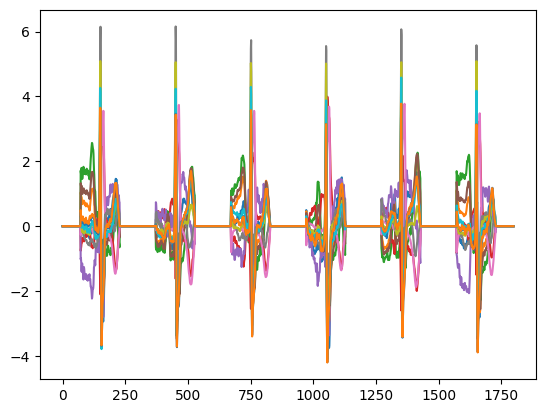

In [14]:
plt.plot(sig[0])

In [15]:
labs = np.load("../dataset/cpsc2018/label/label.npy")
labs

array([[   5,    1],
       [   1,    2],
       [   2,    3],
       ...,
       [   4, 6803],
       [   2, 6804],
       [   7, 6805]], shape=(6805, 2))